In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/ECE 49595CV/Object-Dectection-Circuit-Components'

/content/drive/MyDrive/ECE 49595CV/Object-Dectection-Circuit-Components


In [3]:
import sys
import os
import numpy as np
import cv2 as cv
import pandas as pd
import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image, ImageDraw

In [ ]:
# train = pd.read_csv("data/annotations/annotations.csv")
# train.head()

In [ ]:
# coords = train[['bbox_x', 'bbox_y', 'bbox_width', 'bbox_height']].copy()
# coords.columns = ['x1', 'y1', 'w', 'h']
# coords.head()

,x1,y1,w,h
0,16,21,77,647
1,16,276,76,183
2,30,294,49,8
3,34,322,39,6
4,31,349,51,8


In [ ]:
# df = pd.concat([train, coords], axis = 1)

In [ ]:
# df["x1"] = pd.to_numeric(df["x1"])
# df["y1"] = pd.to_numeric(df["y1"])
# df["w"] = pd.to_numeric(df["w"])
# df["h"] = pd.to_numeric(df["h"])
# label_mapping = {label: idx for idx, label in enumerate(df['label_name'].unique())}
# print(label_mapping)
# df['label_idx'] = df['label_name'].map(label_mapping)

{'Resistor Area': 0, 'Resistor Body': 1, 'Color': 2}


In [ ]:
# df["x2"] = df["x1"] + df["w"]
# df["y2"] = df["y1"] + df["h"]

In [ ]:
# df.drop(['bbox_x', 'bbox_y', 'bbox_width', 'bbox_height', 'image_width', 'image_height', 'w', 'h', 'label_name'], axis = 1, inplace = True)
# df.head()

,image_name,x1,y1,label_idx,x2,y2
0,img1.jpg,16,21,0,93,668
1,img1.jpg,16,276,1,92,459
2,img1.jpg,30,294,2,79,302
3,img1.jpg,34,322,2,73,328
4,img1.jpg,31,349,2,82,357


In [4]:
import pandas as pd
import json

def process_annotations(file_path):
    with open(file_path) as f:
        data = json.load(f)

    image_data = []
    annotations_data = []

    # Getting image metadata from json file
    for image in data['images']:
        image_data.append({
            'image_id': image['id'],
            'file_name': image['file_name'],
            'width': image['width'],
            'height': image['height']
        })

    # Getting annotations from json file
    for ann in data['annotations']:
        annotations_data.append({
            'image_id': ann['image_id'],
            'category_id': ann['category_id'],
            'segmentation': ann['segmentation'][0] if ann['segmentation'] else None
        })

    # Creating dataframe for images metadata
    images_df = pd.DataFrame(image_data)
    # Creating dataframe for annotations
    annotations_df = pd.DataFrame(annotations_data)
    # Merging the two dataframes on image id
    df = pd.merge(annotations_df, images_df, on='image_id')

    # Mapping each category to an index eg: {1: 'Resistor'}
    label_name_mapping = {cat['id']: cat['name'] for cat in data['categories']}
    unique_category_ids = sorted(set(label_name_mapping.keys()))
    # Mapping the index to a number for model eg: {1: 0}
    label_index_mapping = {cat_id: idx for idx, cat_id in enumerate(unique_category_ids)}

    df['label_idx'] = df['category_id'].map(label_index_mapping)

    return df, label_name_mapping, label_index_mapping

df1, label_name_mapping1, label_index_mapping1 = process_annotations("data/annotations/annotations.json")
df2, label_name_mapping2, label_index_mapping2 = process_annotations("data/annotations/annotations1.json")

df = pd.concat([df1, df2], ignore_index=True)
label_index_mapping = {**label_index_mapping1, **label_index_mapping2}
label_name_mapping = {**label_name_mapping1, **label_name_mapping2}

print('Label Name Mapping 1:', label_name_mapping1)
print('Label Index Mapping 1:', label_index_mapping1)
print(df1.head())
print('Label Name Mapping 2:', label_name_mapping2)
print('Label Index Mapping 2:', label_index_mapping2)
print(df2.head())


Label Name Mapping 1: {1: 'Wire', 2: 'Resistor'}
Label Index Mapping 1: {1: 0, 2: 1}
   image_id  category_id                                       segmentation  \
0         1            1  [158.54878424130496, 327.36842105263145, 166.4...   
1         1            1  [224.59679901508147, 661.198060941828, 221.725...   
2         1            2  [185.8294859956909, 626.7382271468141, 183.675...   
3         1            2  [247.5700215450907, 150.04385964912274, 245.41...   
4         1            1  [386.1272699292088, 383.36565096952893, 381.10...   

      file_name  width  height  label_idx  
0  IMG_5270.jpg    700     933          0  
1  IMG_5270.jpg    700     933          0  
2  IMG_5270.jpg    700     933          1  
3  IMG_5270.jpg    700     933          1  
4  IMG_5270.jpg    700     933          0  
Label Name Mapping 2: {1: 'Wire', 2: 'Resistor'}
Label Index Mapping 2: {1: 0, 2: 1}
   image_id  category_id                                       segmentation  \
0         1 

In [5]:
# Getting all the unique imgs from the df
unique_imgs = df['file_name'].unique()
print(unique_imgs, len(unique_imgs))

['IMG_5270.jpg' 'IMG_5271.jpg' 'IMG_5272.jpg' 'IMG_5273.jpg'
 'IMG_5274.jpg' 'IMG_5276.jpg' 'IMG_5277.jpg' 'IMG_5278.jpg'
 'IMG_5279.jpg' 'IMG_5296.jpg' 'IMG_5297.jpg' 'IMG_5298.jpg'
 'IMG_5300.jpg' 'IMG_5301.jpg' 'IMG_5302.jpg' 'IMG_5303.jpg'
 'IMG_5304.jpg' 'IMG_5305.jpg' 'IMG_5306.jpg' 'IMG_5307.png'
 'IMG_5308.jpg' 'IMG_5309.jpg' 'IMG_5310.jpg' '22R_1-4W_(20).jpg'
 '22R_1-4W_(21).jpg' '22R_1-4W_(22).jpg' '22R_1-4W_(23).jpg'
 '22R_1-4W_(24).jpg' '22R_1-4W_(25).jpg' '22R_1-4W_(26).jpg'
 '22R_1-4W_(27).jpg' '22R_1-4W_(28).jpg' '22R_1-4W_(30).jpg'
 '22R_1-4W_(31).jpg' '270K_1-4W_(10).jpg' '270K_1-4W_(11).jpg'
 '270K_1-4W_(12).jpg' '270K_1-4W_(13).jpg' '270K_1-4W_(14).jpg'
 '270K_1-4W_(15).jpg' '270K_1-4W_(16).jpg' '270K_1-4W_(17).jpg'
 '270K_1-4W_(18).jpg' '270K_1-4W_(19).jpg' '270K_1-4W_(2).jpg'
 '270K_1-4W_(3).jpg' '270K_1-4W_(4).jpg' '270K_1-4W_(5).jpg'
 '270K_1-4W_(6).jpg' '270K_1-4W_(7).jpg' '270K_1-4W_(8).jpg'
 '270K_1-4W_(9).jpg' 'IMG_2501.jpg' 'IMG_2502.jpg' 'IMG_2503.jpg'
 'IM

In [6]:
import torch
import os
from PIL import Image
import torchvision.transforms as T
import cv2
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, df, unique_imgs, indices, img_dir, label_index_mapping, new_size):
        # Initialize the dataset with df, a list of unique images, indices for data sampling,
        # the directory of the images, label to idx mapping, and the new size for image resizing.
        self.df = df
        self.unique_imgs = unique_imgs
        self.indices = indices
        self.img_dir = img_dir
        self.label_index_mapping = label_index_mapping
        self.new_size = new_size

    def __len__(self):
        # Number of items in the dataset
        return len(self.indices)

    def __getitem__(self, idx):
        # Getting the filename of the img at idx
        image_name = self.unique_imgs[self.indices[idx]]
        # Getting data for the img
        img_data = self.df[self.df.file_name == image_name]
        # Loading and converting the img to RGB
        img = Image.open(os.path.join(self.img_dir, image_name)).convert("RGB")

        orig_width, orig_height = img.width, img.height
        # Scaling factors for width and height based on new image size (new_width / old_width )
        width_scale = self.new_size[0] / img.width
        height_scale = self.new_size[1] / img.height

        # Resizing the img
        img = img.resize(self.new_size, Image.ANTIALIAS)

        masks = []
        boxes = []
        labels = []
        for _, row in img_data.iterrows():
            # Process each annotation for the img
            poly = np.array(row['segmentation']).reshape(-1, 2)
            # print('poly-shape:', poly.shape)
            # Scaling the annotation since img is resized
            scaled_poly = self.scale_polygon(poly, width_scale, height_scale)
            if (scaled_poly.size == 0):
              continue

            # Generate masks from polygons
            mask = self.polygons_to_mask(scaled_poly, self.new_size[0], self.new_size[1])
            masks.append(mask)

            # Calculate bounding boxes from scaled polygons
            x_coordinates, y_coordinates = zip(*scaled_poly)
            min_x, max_x, min_y, max_y = min(x_coordinates), max(x_coordinates), min(y_coordinates), max(y_coordinates)
            boxes.append([min_x, min_y, max_x, max_y])

            # Map category ID to a label index
            label_idx = self.label_index_mapping[row['category_id']]
            labels.append(label_idx)

        if orig_width > orig_height:
          #Adjust orientation of masks if needed (when width > height)
          masks = self.adjust_orientation(img, masks)
          # Recalculate bounding boxes from masks
          boxes = self.get_bounding_boxes_from_masks(masks)

        # Convert PIL Image to a PyTorch tensor
        img_tensor = T.ToTensor()(img)

        # Visualization of the image, masks, and bounding boxes
        fig, ax = plt.subplots(1)
        ax.imshow(img)

        for box, mask, label in zip(boxes, masks, labels):
            # Plot bounding boxes and masks
            min_x, min_y, max_x, max_y = box
            rect = patches.Rectangle((min_x, min_y), max_x - min_x, max_y - min_y, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Mask
            mask_img = np.ma.masked_where(mask == 0, mask)
            ax.imshow(mask_img, cmap='cool', alpha=0.5)

            # Displaying labels
            ax.text(box[0], box[1], str(label), color='white', fontsize=12, verticalalignment='top')

        plt.show()

        # Prepare the target dict for model training
        target = {'boxes': torch.tensor(boxes, dtype=torch.float32), 'labels': torch.tensor(labels, dtype=torch.int64), 'masks': torch.tensor(masks, dtype=torch.uint8)}
        return img_tensor, target

    @staticmethod
    def scale_polygon(poly, ws, hs):
        # Scale polygon by using width and height scaling
        scaled_polygon = poly * [ws, hs]
        return np.clip(scaled_polygon, a_min=0, a_max=None)

    @staticmethod
    def polygons_to_mask(polygon, width, height):
        # Create a mask for a given polygon
        mask = np.zeros((height, width), dtype=np.uint8)
        int_polygon = np.array(polygon, dtype=np.int32).reshape(-1, 2)
        cv2.fillPoly(mask, [int_polygon], 1)
        return mask

    @staticmethod
    def adjust_orientation(img, masks):
        # Rotate masks if the image width is greater than its height
        return [np.rot90(mask) for mask in masks]

    @staticmethod
    def get_bounding_boxes_from_masks(masks, min_box_size=1):
        boxes = []
        for mask in masks:
            pos = np.where(mask)
            if pos[0].size > 0 and pos[1].size > 0:
                min_y, min_x = np.min(pos, axis=1)
                max_y, max_x = np.max(pos, axis=1)

                if max_y == min_y:
                    max_y += min_box_size
                if max_x == min_x:
                    max_x += min_box_size

                boxes.append([min_x, min_y, max_x, max_y])
        return boxes


In [7]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, new_size):
        self.img_dir = img_dir
        self.image_names = os.listdir(img_dir)
        self.transform = T.Compose([
            T.Resize(new_size),
            T.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        img = Image.open(os.path.join(self.img_dir, image_name)).convert("RGB")
        img = self.transform(img)
        return img, image_name


In [8]:
def train_val_test_split(unique_imgs, train_ratio=0.7, val_ratio=0.3):
    total_imgs = len(unique_imgs)

    train_count = int(train_ratio * total_imgs)
    val_count = int(val_ratio * total_imgs)

    assert train_count + val_count <= total_imgs, "Sum of training and validation counts should not exceed total image count"

    indices = np.arange(total_imgs)
    np.random.shuffle(indices)

    train_inds = indices[:train_count]
    val_inds = indices[train_count:train_count + val_count]

    return train_inds, val_inds

train_ratio = 0.9
val_ratio = 0.1

train_inds, val_inds = train_val_test_split(unique_imgs, train_ratio=train_ratio, val_ratio=val_ratio)

print(f"Train inds: {train_inds}, Validation inds: {val_inds}")
print(f"Train count: {len(train_inds)}, Validation count: {len(val_inds)}")

Train inds: [49 52 36 46 24 54 16 32 29 47 51 38 34 35 55  4 40  3  9 23 31 26 37 22
  8 42 10 12  7  0 18 27 45 33 19 13 39 20 21 41 50 11 30 28  1 17 53 44
 14 43], Validation inds: [ 5 48  6  2 15]
Train count: 50, Validation count: 5


In [10]:
# from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights, FasterRCNN_ResNet50_FPN_V2_Weights
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 155MB/s]


In [9]:
def custom_collate(data):
  return data

train_dir = "data/train/"
val_dir = "data/train/"
test_dir = "data/test/"

new_size = (400, 400)

train_dl = torch.utils.data.DataLoader(TrainDataset(df, unique_imgs, train_inds, train_dir, label_index_mapping=label_index_mapping, new_size=new_size),
                              batch_size = 16,
                              shuffle = True,
                              collate_fn = custom_collate,
                              pin_memory = True if torch.cuda.is_available() else False)

val_dl = torch.utils.data.DataLoader(TrainDataset(df, unique_imgs, val_inds, train_dir, label_index_mapping=label_index_mapping, new_size=new_size),
                              batch_size = 16,
                              shuffle = True,
                              collate_fn = custom_collate,
                              pin_memory = True if torch.cuda.is_available() else False)


In [16]:
test_dl = torch.utils.data.DataLoader(TestDataset(test_dir, new_size=new_size),
                              batch_size = 8,
                              shuffle = False)

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [12]:
optimizer = torch.optim.SGD(model.parameters(),
                    lr = 0.0001,
                    momentum = 0.9,
                    weight_decay = 0.0005)
num_epochs = 5
log_interval = 1

In [13]:
def check_tensor_sizes(boxes, labels, scores):
    if boxes.size(0) == labels.size(0) == scores.size(0):
        return True
    else:
        return False

model.to(device)
for epochs in range(num_epochs):
    model.train()
    train_loss = 0
    epoch_loss = 0
    for data in train_dl:
        print('Training...')
        imgs, valid_targets = [], []
        for d in data:
            img = d[0].to(device)
            targ = {'masks': d[1]['masks'].to(device),
                    'labels': d[1]['labels'].to(device),
                    'boxes': d[1]['boxes'].to(device)}
            if targ['boxes'].nelement() != 0:
                imgs.append(img)
                valid_targets.append(targ)

        if len(imgs) > 0 and len(valid_targets) > 0:
            loss_dict = model(imgs, valid_targets)
            loss = sum(loss for loss in loss_dict.values())
            epoch_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # print("Epoch: {}, Loss: {}".format(epochs, epoch_loss))

    model.eval()
    with torch.no_grad():
      val_loss = 0
      for val_batch in val_dl:
        print('Validating...')
        val_imgs = []
        val_targets = []
        for d in val_batch:
            val_imgs.append(d[0].to(device))
            val_targ = {}
            val_targ['masks'] = d[1]['masks'].to(device)
            val_targ['labels'] = d[1]['labels'].to(device)
            val_targ['boxes'] = d[1]['boxes'].to(device)
            val_targets.append(val_targ)

        val_outputs = model(val_imgs, val_targets)
        # print('vo', val_outputs)
        for output in val_outputs:
          print("Boxes shape:", output['boxes'].shape)
          print("Labels shape:", output['labels'].shape)
          print("Scores shape:", output['scores'].shape)
          if not check_tensor_sizes(output['boxes'], output['labels'], output['scores']):
            print("Size mismatch detected, skipping batch")
            continue
            print('output_vals', output.values())
            lc = sum(loss for loss in output.values())
            val_loss += lc

      print('val_dl', val_dl)
      val_loss /= len(val_dl)

      print(f"Epoch: {epochs}, Training Loss: {epoch_loss / len(train_dl)}, Validation Loss: {val_loss}")


Filtered Labels: ['Resistor']
Filtered Scores: [0.2902655601501465]


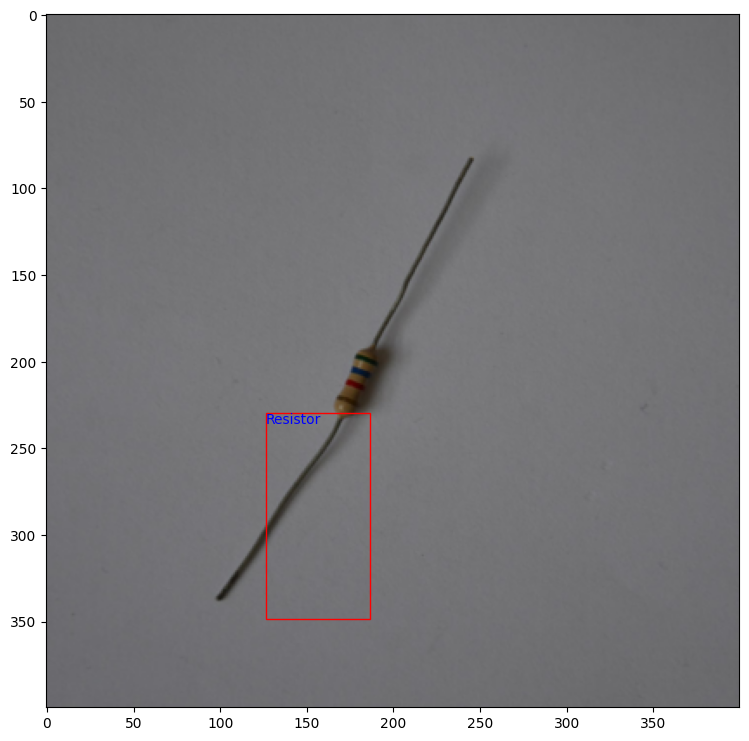

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

dataloader = test_dl
l
label_name_mapping = {1: "Resistor", 2: "Wire"}
model.eval()

threshold = 0.2

for data in dataloader:
    img_tensor, annotations = data[0][0].to(device), data[0][1]

    with torch.no_grad():
        output = model([img_tensor])

    filtered_boxes = []
    filtered_labels = []
    filtered_scores = []

    for score, label, box in zip(output[0]["scores"], output[0]["labels"], output[0]["boxes"]):
        if score > threshold:
            filtered_boxes.append(box.cpu().numpy())
            filtered_labels.append(label_name_mapping[label.item()])
            filtered_scores.append(score.item())

    print("Filtered Labels:", filtered_labels)
    print("Filtered Scores:", filtered_scores)

    image_np = img_tensor.cpu().numpy().transpose(1, 2, 0)

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image_np)

    for box, label in zip(filtered_boxes, filtered_labels):
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(box[0], box[1], label, color='blue', fontsize=10, verticalalignment='top')

    plt.show()


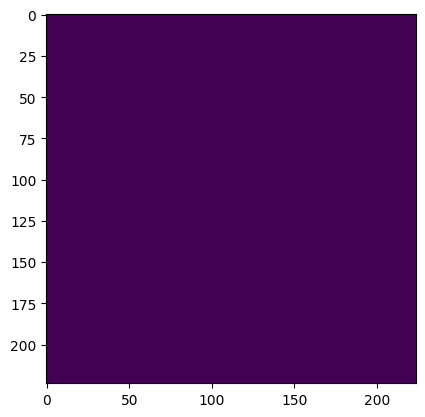

In [ ]:
import cv2
import numpy as np

def sobel_edge_detection(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    sobelx = cv2.Sobel(blur, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(blur, cv2.CV_64F, 0, 1, ksize=5)
    sobel = cv2.addWeighted(np.absolute(sobelx), 0.5, np.absolute(sobely), 0.5, 0)
    _, thresh = cv2.threshold(sobel, 200, 255, cv2.THRESH_BINARY)
    return thresh

for box, label in zip(boxes.cpu(), label_names):
    if label == 'Color':
        x = int(box[0])
        y = int(box[1])
        w = int(box[2] - box[0])
        h = int(box[3] - box[1])
        roi = image_np[y:y+h, x:x+w]
        roi = cv2.resize(roi, (224, 224))
        roi = sobel_edge_detection(roi)
        plt.imshow(roi)
        plt.show()
        break